**Libaries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.metrics import roc_curve, auc
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from flask import Flask, render_template, request
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pickle
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

**Data Cleaning**

In [2]:
# Load data set and target variable

df = pd.read_csv('../data/leads.csv')
target_variable = 'Converted'
missing_values = df.isnull().sum()
print(missing_values)

Prospect ID                            0
Lead Number                            0
Lead Origin                            0
Lead Source                            0
Do Not Email                           0
Do Not Call                            0
TotalVisits                          137
Total Time Spent on Website            0
Page Views Per Visit                 137
Last Activity                        986
Country                              907
Industry                            1438
How did you hear about us           2207
Search                                 0
Magazine                               0
Newspaper Article                      0
Forums                                 0
Newspaper                              0
Digital Advertisement                  0
Through Recommendations                0
Product Interested                     0
Lead Quality                        4767
Lead Profile                        2709
Asymmetrique Activity Index         4218
Asymmetrique Pro

In [3]:
df.dtypes

Prospect ID                          object
Lead Number                           int64
Lead Origin                          object
Lead Source                          object
Do Not Email                         object
Do Not Call                          object
TotalVisits                         float64
Total Time Spent on Website           int64
Page Views Per Visit                float64
Last Activity                        object
Country                              object
Industry                             object
How did you hear about us            object
Search                               object
Magazine                             object
Newspaper Article                    object
Forums                               object
Newspaper                            object
Digital Advertisement                object
Through Recommendations              object
Product Interested                   object
Lead Quality                         object
Lead Profile                    

In [4]:
# Dropping irrelevant columns and columns not part of the 8 most correlated with the target feature, as per previous analysis since deleted

df.drop(['Prospect ID', 'Lead Number', 'Magazine', 'Do Not Call', 'TotalVisits', 'Page Views Per Visit', 'Country', 'Industry', 'How did you hear about us', 'Search', 'Magazine', 'Newspaper Article', 'Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Product Interested', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'A free copy of Mastering The CRM', 'Last Notable Activity'], axis=1, inplace=True)

In [5]:
df.dtypes

Lead Origin                     object
Lead Source                     object
Do Not Email                    object
Total Time Spent on Website      int64
Last Activity                   object
Lead Quality                    object
Lead Profile                    object
Asymmetrique Profile Score     float64
Converted                        int64
dtype: object

In [6]:
# Make column names lower case with underscores

df.columns = [col.replace(' ', '_').lower() for col in df.columns]

In [7]:
df.head()

,lead_origin,lead_source,do_not_email,total_time_spent_on_website,last_activity,lead_quality,lead_profile,asymmetrique_profile_score,converted
0,API,Drift,No,0,Page Visited on Website,Low in Relevance,Select,15.0,0
1,API,Organic Search,No,674,Email Opened,NaN,Select,15.0,0
2,Landing Page Submission,Direct Traffic,No,1532,Email Opened,Might be,Potential Lead,20.0,1
3,Landing Page Submission,Direct Traffic,No,305,Unreachable,Not Sure,Select,17.0,0
4,Landing Page Submission,Google,No,1428,Converted to Lead,Might be,Select,18.0,1


**Feature Engineering**

In [8]:
y = df['converted']
X = df.drop('converted', axis =1)

In [9]:
X.head()

,lead_origin,lead_source,do_not_email,total_time_spent_on_website,last_activity,lead_quality,lead_profile,asymmetrique_profile_score
0,API,Drift,No,0,Page Visited on Website,Low in Relevance,Select,15.0
1,API,Organic Search,No,674,Email Opened,NaN,Select,15.0
2,Landing Page Submission,Direct Traffic,No,1532,Email Opened,Might be,Potential Lead,20.0
3,Landing Page Submission,Direct Traffic,No,305,Unreachable,Not Sure,Select,17.0
4,Landing Page Submission,Google,No,1428,Converted to Lead,Might be,Select,18.0


In [10]:
# Identify categorical and numeric features

categorical_columns = X.select_dtypes(include=['object']).columns

# Identify numerical columns

numerical_columns = X.select_dtypes(include=['float64']).columns

In [11]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing

class ColumnFilter(BaseEstimator, TransformerMixin):
    def __init__(self, trained_columns):
        self.trained_columns = trained_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.trained_columns]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(drop= 'first',handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

**Baseline Model - Decision Tree**

In [13]:
# Create the decision tree pipeline

from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing step
    ('dt_classifier', DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2))  # Decision tree classifier
])

# Train the model with training data

# Fit the pipeline to your training data
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['asymmetrique_profile_score'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['lead_origin', 'lead_source', 'do_not_email', 'last_activity',
       'lead_quality', 'lead_profile'],
      dtype='object'))])),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2))])

In [14]:
# Make predictions with testing data

y_pred = dt_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.7035
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.94      0.79      1107
           1       0.80      0.35      0.48       741

    accuracy                           0.70      1848
   macro avg       0.74      0.64      0.64      1848
weighted avg       0.73      0.70      0.67      1848



Confusion Matrix

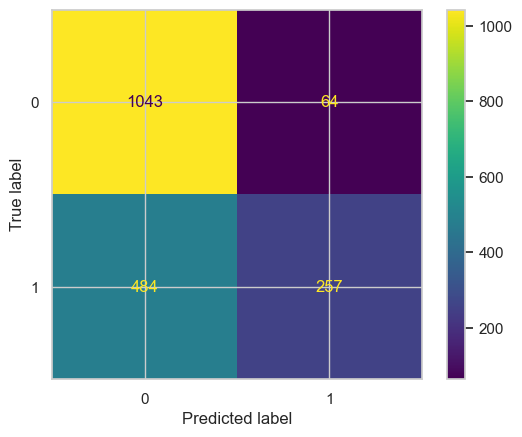

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**XGBoost Model**

Best parameters: {'xgboost_classifier__colsample_bytree': 0.6, 'xgboost_classifier__gamma': 0.1, 'xgboost_classifier__learning_rate': 0.5, 'xgboost_classifier__max_depth': 5, 'xgboost_classifier__min_child_weight': 2, 'xgboost_classifier__n_estimators': 100}

In [16]:
# Create an XGBoost classifier pipeline

xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgboost_classifier', XGBClassifier(random_state=42, learning_rate=0.5, max_depth=5, n_estimators=100, colsample_bytree=0.6, min_child_weight=2, gamma=0.1))
])

# Train the pipeline (including preprocessing and classifier training)

xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['asymmetrique_profile_score'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['lea...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [17]:
# Make predictions with testing data

y_pred = xgboost_pipeline.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8122
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      1107
           1       0.78      0.74      0.76       741

    accuracy                           0.81      1848
   macro avg       0.81      0.80      0.80      1848
weighted avg       0.81      0.81      0.81      1848



Confusion Matrix

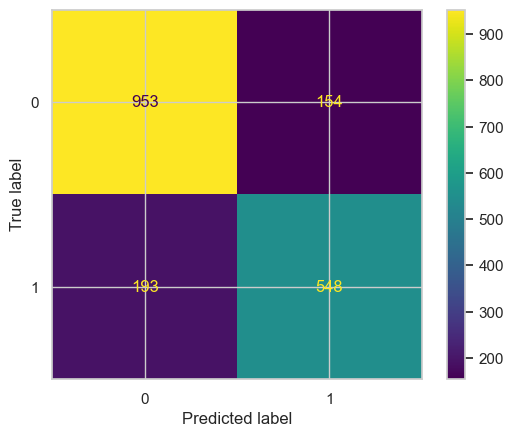

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**ROC-AUC Curve Comparison**

In [19]:
# Predict probabilities for each model

y_pred_prob_dt = dt_pipeline.predict_proba(X_test)[:, 1]
y_pred_prob_xgboost = xgboost_pipeline.predict_proba(X_test)[:, 1]

In [20]:
# Calculate ROC curve and AUC for each model

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_xgboost, tpr_xgboost, _ = roc_curve(y_test, y_pred_prob_xgboost)
roc_auc_xgboost = auc(fpr_xgboost, tpr_xgboost)

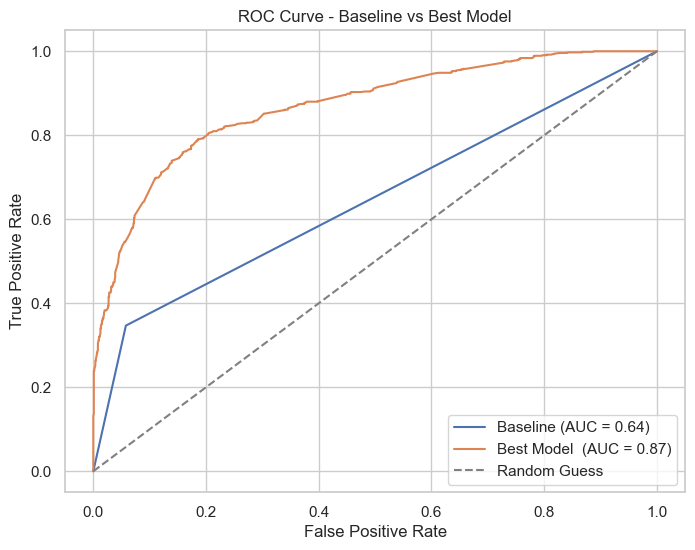

In [21]:
# Plot the ROC curves

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Baseline (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_xgboost, tpr_xgboost, label=f'Best Model  (AUC = {roc_auc_xgboost:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline vs Best Model')
plt.legend()
plt.show()

**Precision-Recall Curve**

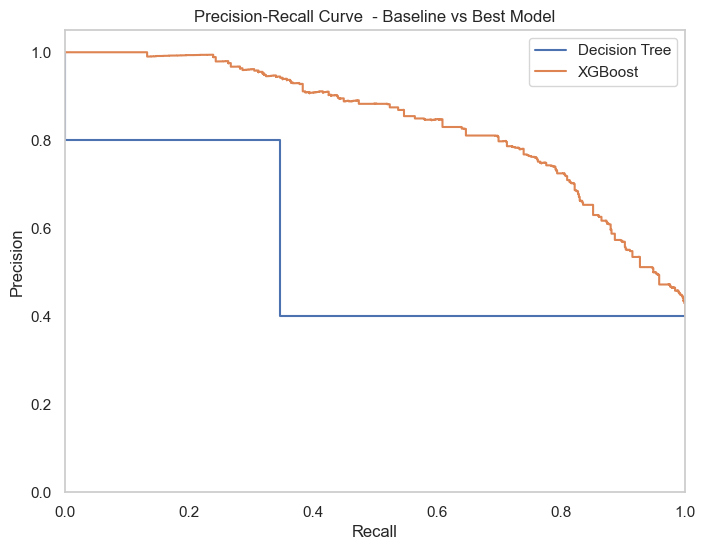

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Make predictions on your test data

y_pred1 = dt_pipeline.predict_proba(X_test)[:, 1]
y_pred2 = xgboost_pipeline.predict_proba(X_test)[:, 1]

# Step 3: Calculate precision and recall values at different thresholds
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)

# Step 4: Plot the precision-recall curves
plt.figure(figsize=(8, 6))
plt.step(recall1, precision1, where='post', label='Decision Tree')
plt.step(recall2, precision2, where='post', label='XGBoost')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve  - Baseline vs Best Model')
plt.legend(loc='best')
plt.grid()
plt.show()

**Export Best Model**

**Grid Search CV - XGBoost**

In [24]:
from sklearn.model_selection import GridSearchCV

# XGBoost Model

model = xgboost_pipeline

# Define the parameter grid to search

param_grid = {
    'xgboost_classifier__max_depth': [3, 4, 5, 6, 7],
    'xgboost_classifier__n_estimators': [100, 200, 300],
    'xgboost_classifier__learning_rate': [0.3, 0.4, 0.5, 0.6],
    'xgboost_classifier__min_child_weight': [1, 2, 3],
    'xgboost_classifier__colsample_bytree': [0.6, 0.7, 0.8],
    'xgboost_classifier__gamma': [0.1, 1, 2]
}

# Create a GridSearchCV object

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

In [25]:
# Perform the grid search on the training data

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['asymmetrique_profile_score'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unkn...
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgboost_classifier__colsample_bytree': [0.6, 0.7,
                                                                  0.8],
                         'xgboost_classifier__gamma': [0.1, 1, 2],
                         'xgboost_classifier__learning_rate': [0.3, 0.4, 0.5,
                                                               0.6],
                         'xgboost_classifier__max_depth': [3, 4, 5, 6, 7],
                         'xgboost_classifier__min_child_weight': [1, 2, 3],
                         'xgboost_classifier__n_estimators': [100, 200, 300]},
             verbose=2)

In [26]:
# Show best parameters

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

Best parameters: {'xgboost_classifier__colsample_bytree': 0.6, 'xgboost_classifier__gamma': 0.1, 'xgboost_classifier__learning_rate': 0.5, 'xgboost_classifier__max_depth': 5, 'xgboost_classifier__min_child_weight': 2, 'xgboost_classifier__n_estimators': 100}


In [39]:
import joblib

# Save XGBoost model to file

joblib.dump(best_model, 'xgboost_classifier.joblib')

['xgboost_classifier.joblib']

**Feature Importance**

In [27]:
# Exporting feature importance for the xgboost classifier

xgboost_classifier = xgboost_pipeline.named_steps['xgboost_classifier']

# Extracting feature importances
feature_importances = xgboost_classifier.feature_importances_

# Create a DataFrame for easy handling
feature_names = xgboost_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Save the DataFrame for later use in the app
importances_df.to_csv('leads_feature_importances.csv', index=False)

In [40]:
# Assuming 'df' is your DataFrame and 'Converted' is your target variable
correlation_matrix = df.corr()

# Extracting correlations with 'Converted'
converted_correlations = correlation_matrix['Converted'].sort_values(ascending=False)

# Modify this to include or exclude specific features as needed
top_features = converted_correlations.head(9).drop(['Converted', 'some_other_feature'])
if 'specific_feature' not in top_features:
    top_features['specific_feature'] = converted_correlations['specific_feature']

# Plotting the correlations with 'Converted' for selected features, but swapping axes
plt.figure(figsize=(6, 8))
top_features.plot(kind='barh', color='#FF794A')  # Use 'barh' for horizontal bars

# Customizing plot aesthetics (colors, labels, title)
plt.title('Correlation of Selected Features with Conversion', color='white')
plt.ylabel('Features', color='white')
plt.xlabel('Correlation Coefficient', color='white')
plt.yticks(color='white')
plt.xticks(color='white')

# Adjusting axes colors
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Setting background color
plt.gca().set_facecolor('#121212')
plt.gca().figure.set_facecolor('#121212')

# Display the plot
plt.show()


ValueError: could not convert string to float: '7927b2df-8bba-4d29-b9a2-b6e0beafe620'